In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [3]:
os.listdir('/kaggle/input/soil-classification/soil_classification-2025/train')[:5]

['img_3c4ed833.jpeg',
 'img_8163dc71.jpg',
 'img_e48dfef4.jpg',
 'img_83d433d2.jpg',
 'img_4b62f891.jpeg']

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [5]:
train = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')

display(train.head())

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [6]:
le = LabelEncoder()
train["label_encoded"] = le.fit_transform(train["soil_type"])

In [7]:
display(train.head())

,image_id,soil_type,label_encoded
0,img_ed005410.jpg,Alluvial soil,0
1,img_0c5ecd2a.jpg,Alluvial soil,0
2,img_ed713bb5.jpg,Alluvial soil,0
3,img_12c58874.jpg,Alluvial soil,0
4,img_eff357af.jpg,Alluvial soil,0


In [8]:
train["label"] = train["soil_type"]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


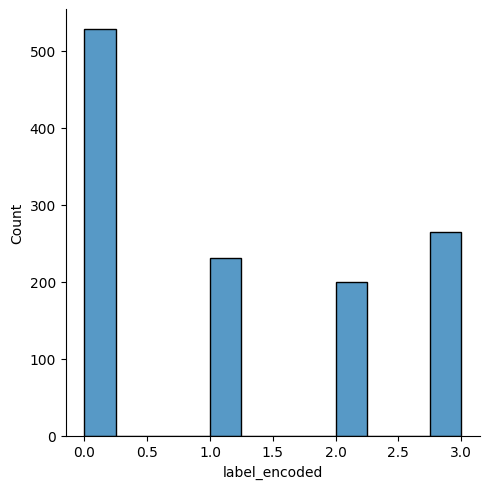

In [9]:
sns.displot(train['label_encoded'], kde=False)

In [10]:
train["soil_type"].value_counts()

soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64

In [11]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '/kaggle/input/soil-classification/soil_classification-2025/train'
TEST_PATH = '/kaggle/input/soil-classification/soil_classification-2025/test'

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b7_ns'  #'resnext50_32x4d'
    size=512
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=4
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=4
    target_col='label_encoded'
    n_fold=5
    trn_fold=[0,1,2,3,4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [13]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import *
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return f1_score(y_true, y_pred,average='macro')


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [15]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label_encoded
0     0                106
      1                 46
      2                 40
      3                 53
1     0                106
      1                 47
      2                 40
      3                 52
2     0                106
      1                 46
      2                 39
      3                 53
3     0                105
      1                 46
      2                 40
      3                 53
4     0                105
      1                 46
      2                 40
      3                 53
dtype: int64


In [16]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label_encoded'].values
        self.foldername = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        folder_name = self.foldername[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image_id']
        return image

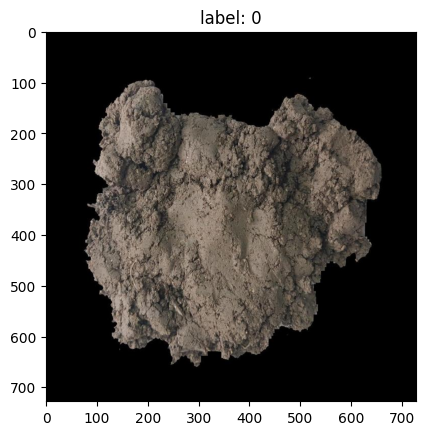

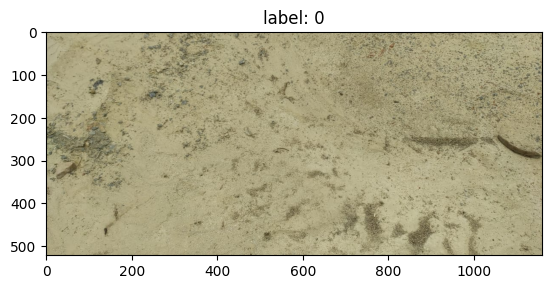

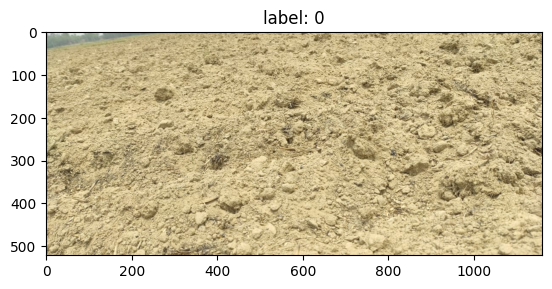

In [17]:
train_dataset = TrainDataset(train, transform=None)

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [18]:
CFG.size

512

In [19]:
from albumentations import Resize

In [20]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop((CFG.size, CFG.size)),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [21]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

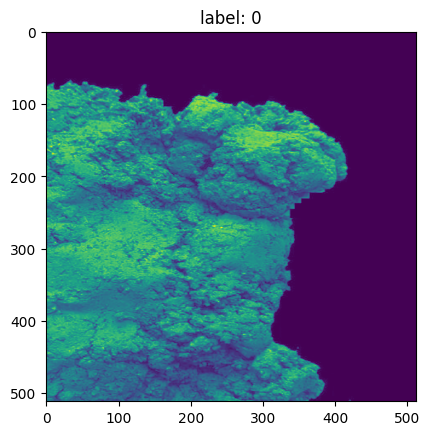

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [24]:
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0488, -0.0126,  0.0396,  0.0909],
        [ 0.0691, -0.0789, -0.0037,  0.0137],
        [ 0.0619, -0.0712,  0.0037,  0.0221],
        [ 0.1066, -0.1463,  0.4570,  0.5201]], grad_fn=<AddmmBackward0>)


In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [26]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - F1 SCORE: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth',weights_only = False)
    print( len(check_point['preds']))

    valid_folds[[str(c) for c in range(4)]] = check_point['preds']
    
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds


In [27]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

Epoch: [1][0/244] Data 0.689 (0.689) Elapsed 0m 2s (remain 9m 55s) Loss: 1.3719(1.3719) Grad: 4.8435  
Epoch: [1][100/244] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 39s) Loss: 1.3155(0.8623) Grad: 9.3266  
Epoch: [1][200/244] Data 0.000 (0.005) Elapsed 2m 23s (remain 0m 30s) Loss: 1.3381(0.7557) Grad: 7.8126  
Epoch: [1][243/244] Data 0.000 (0.006) Elapsed 2m 55s (remain 0m 0s) Loss: 0.1864(0.7284) Grad: 2.8961  
EVAL: [0/62] Data 0.693 (0.693) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0419(0.0419) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.2877(0.3963) 


Epoch 1 - avg_train_loss: 0.7284  avg_val_loss: 0.3963  time: 189s
Epoch 1 - F1 SCORE: 0.8852538203258529
Epoch 1 - Save Best Score: 0.8853 Model


Epoch: [2][0/244] Data 0.665 (0.665) Elapsed 0m 1s (remain 4m 17s) Loss: 0.7009(0.7009) Grad: 8.7728  
Epoch: [2][100/244] Data 0.000 (0.010) Elapsed 1m 13s (remain 1m 44s) Loss: 0.3047(0.5536) Grad: 5.0998  
Epoch: [2][200/244] Data 0.000 (0.007) Elapsed 2m 26s (remain 0m 31s) Loss: 0.2213(0.5548) Grad: 2.8436  
Epoch: [2][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.6798(0.5352) Grad: 8.8730  
EVAL: [0/62] Data 0.653 (0.653) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0004(0.0004) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1033(0.3231) 


Epoch 2 - avg_train_loss: 0.5352  avg_val_loss: 0.3231  time: 191s
Epoch 2 - F1 SCORE: 0.8863335328869306
Epoch 2 - Save Best Score: 0.8863 Model


Epoch: [3][0/244] Data 0.639 (0.639) Elapsed 0m 1s (remain 4m 6s) Loss: 0.3079(0.3079) Grad: 5.2238  
Epoch: [3][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.3184(0.4514) Grad: 5.1712  
Epoch: [3][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.4738(0.4101) Grad: 4.7801  
Epoch: [3][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.1222(0.3983) Grad: 2.5062  
EVAL: [0/62] Data 0.653 (0.653) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0943(0.0943) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.8040(0.3037) 


Epoch 3 - avg_train_loss: 0.3983  avg_val_loss: 0.3037  time: 192s
Epoch 3 - F1 SCORE: 0.876423192734631


Epoch: [4][0/244] Data 0.644 (0.644) Elapsed 0m 1s (remain 4m 12s) Loss: 0.0431(0.0431) Grad: 0.7972  
Epoch: [4][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1737(0.3332) Grad: 3.1052  
Epoch: [4][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0887(0.3517) Grad: 2.1067  
Epoch: [4][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.4431(0.3572) Grad: 6.3861  
EVAL: [0/62] Data 0.692 (0.692) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0087(0.0087) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0735(0.2501) 


Epoch 4 - avg_train_loss: 0.3572  avg_val_loss: 0.2501  time: 192s
Epoch 4 - F1 SCORE: 0.9103979486815137
Epoch 4 - Save Best Score: 0.9104 Model


Epoch: [5][0/244] Data 0.706 (0.706) Elapsed 0m 1s (remain 4m 25s) Loss: 0.0846(0.0846) Grad: 2.0544  
Epoch: [5][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0619(0.3446) Grad: 1.1974  
Epoch: [5][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0360(0.3185) Grad: 0.8418  
Epoch: [5][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.5127(0.3210) Grad: 8.1214  
EVAL: [0/62] Data 0.699 (0.699) Elapsed 0m 0s (remain 0m 54s) Loss: 0.1912(0.1912) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1777(0.2377) 


Epoch 5 - avg_train_loss: 0.3210  avg_val_loss: 0.2377  time: 192s
Epoch 5 - F1 SCORE: 0.9180738560259166
Epoch 5 - Save Best Score: 0.9181 Model


Epoch: [6][0/244] Data 0.703 (0.703) Elapsed 0m 1s (remain 4m 32s) Loss: 0.1805(0.1805) Grad: 3.8525  
Epoch: [6][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1545(0.3268) Grad: 3.3016  
Epoch: [6][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0065(0.2764) Grad: 0.1327  
Epoch: [6][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.4010(0.2746) Grad: 7.4359  
EVAL: [0/62] Data 0.691 (0.691) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0016(0.0016) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1634(0.2277) 


Epoch 6 - avg_train_loss: 0.2746  avg_val_loss: 0.2277  time: 192s
Epoch 6 - F1 SCORE: 0.8894384231274961


Epoch: [7][0/244] Data 0.668 (0.668) Elapsed 0m 1s (remain 4m 15s) Loss: 0.1914(0.1914) Grad: 2.9387  
Epoch: [7][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.2826(0.2284) Grad: 4.0994  
Epoch: [7][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0395(0.2206) Grad: 1.1903  
Epoch: [7][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0193(0.2279) Grad: 0.5561  
EVAL: [0/62] Data 0.710 (0.710) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0086(0.0086) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1176(0.2175) 


Epoch 7 - avg_train_loss: 0.2279  avg_val_loss: 0.2175  time: 192s
Epoch 7 - F1 SCORE: 0.9085947854728842


Epoch: [8][0/244] Data 0.638 (0.638) Elapsed 0m 1s (remain 4m 9s) Loss: 1.2756(1.2756) Grad: 11.2714  
Epoch: [8][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1878(0.2217) Grad: 4.5174  
Epoch: [8][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1604(0.1957) Grad: 3.6652  
Epoch: [8][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0345(0.1934) Grad: 0.6183  
EVAL: [0/62] Data 0.682 (0.682) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0072(0.0072) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0891(0.1828) 


Epoch 8 - avg_train_loss: 0.1934  avg_val_loss: 0.1828  time: 192s
Epoch 8 - F1 SCORE: 0.9323448052605579
Epoch 8 - Save Best Score: 0.9323 Model


Epoch: [9][0/244] Data 0.655 (0.655) Elapsed 0m 1s (remain 4m 20s) Loss: 0.0169(0.0169) Grad: 0.4314  
Epoch: [9][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1307(0.2038) Grad: 4.2543  
Epoch: [9][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0327(0.1771) Grad: 0.7746  
Epoch: [9][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0277(0.2055) Grad: 0.9062  
EVAL: [0/62] Data 0.720 (0.720) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0129(0.0129) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0866(0.1577) 


Epoch 9 - avg_train_loss: 0.2055  avg_val_loss: 0.1577  time: 192s
Epoch 9 - F1 SCORE: 0.9376480437801192
Epoch 9 - Save Best Score: 0.9376 Model


Epoch: [10][0/244] Data 0.654 (0.654) Elapsed 0m 1s (remain 4m 14s) Loss: 0.0082(0.0082) Grad: 0.2639  
Epoch: [10][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0067(0.1834) Grad: 0.1626  
Epoch: [10][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0600(0.1786) Grad: 1.4520  
Epoch: [10][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0388(0.1867) Grad: 1.1770  
EVAL: [0/62] Data 0.669 (0.669) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0108(0.0108) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.1311(0.1925) 


Epoch 10 - avg_train_loss: 0.1867  avg_val_loss: 0.1925  time: 192s
Epoch 10 - F1 SCORE: 0.911490415929476
========== fold: 0 result ==========
Score: 0.93765
========== fold: 1 training ==========


245
Epoch: [1][0/244] Data 0.691 (0.691) Elapsed 0m 1s (remain 5m 49s) Loss: 1.3779(1.3779) Grad: 5.4984  
Epoch: [1][100/244] Data 0.000 (0.007) Elapsed 1m 14s (remain 1m 45s) Loss: 1.7556(0.8571) Grad: 10.8386  
Epoch: [1][200/244] Data 0.000 (0.005) Elapsed 2m 27s (remain 0m 31s) Loss: 0.8670(0.7444) Grad: 6.4052  
Epoch: [1][243/244] Data 0.000 (0.006) Elapsed 2m 58s (remain 0m 0s) Loss: 0.2515(0.6854) Grad: 4.0881  
EVAL: [0/62] Data 0.709 (0.709) Elapsed 0m 0s (remain 0m 54s) Loss: 0.1538(0.1538) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1497(0.3705) 


Epoch 1 - avg_train_loss: 0.6854  avg_val_loss: 0.3705  time: 192s
Epoch 1 - F1 SCORE: 0.8872437389361091
Epoch 1 - Save Best Score: 0.8872 Model


Epoch: [2][0/244] Data 0.599 (0.599) Elapsed 0m 0s (remain 3m 56s) Loss: 1.0315(1.0315) Grad: 13.0833  
Epoch: [2][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.1836(0.5716) Grad: 2.6103  
Epoch: [2][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.8266(0.5395) Grad: 9.8733  
Epoch: [2][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 1.6757(0.5517) Grad: 8.8891  
EVAL: [0/62] Data 0.710 (0.710) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0578(0.0578) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.7895(0.3108) 


Epoch 2 - avg_train_loss: 0.5517  avg_val_loss: 0.3108  time: 192s
Epoch 2 - F1 SCORE: 0.9044925972985853
Epoch 2 - Save Best Score: 0.9045 Model


Epoch: [3][0/244] Data 0.658 (0.658) Elapsed 0m 1s (remain 4m 14s) Loss: 0.2168(0.2168) Grad: 2.6391  
Epoch: [3][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.3027(0.4222) Grad: 5.2071  
Epoch: [3][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.3778(0.4238) Grad: 5.9363  
Epoch: [3][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.2877(0.4242) Grad: 4.9563  
EVAL: [0/62] Data 0.692 (0.692) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0179(0.0179) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1938(0.3160) 


Epoch 3 - avg_train_loss: 0.4242  avg_val_loss: 0.3160  time: 191s
Epoch 3 - F1 SCORE: 0.8988544310096034


Epoch: [4][0/244] Data 0.686 (0.686) Elapsed 0m 1s (remain 4m 21s) Loss: 0.1899(0.1899) Grad: 3.3587  
Epoch: [4][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1259(0.3653) Grad: 3.1397  
Epoch: [4][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1189(0.3665) Grad: 2.4379  
Epoch: [4][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.0523(0.3568) Grad: 1.0763  
EVAL: [0/62] Data 0.712 (0.712) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0083(0.0083) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0100(0.2531) 


Epoch 4 - avg_train_loss: 0.3568  avg_val_loss: 0.2531  time: 192s
Epoch 4 - F1 SCORE: 0.8914300804462529


Epoch: [5][0/244] Data 0.627 (0.627) Elapsed 0m 1s (remain 4m 4s) Loss: 1.6192(1.6192) Grad: 15.1408  
Epoch: [5][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0408(0.3489) Grad: 1.0221  
Epoch: [5][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 4.5117(0.3407) Grad: 14.3221  
Epoch: [5][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.3520(0.3615) Grad: 4.4722  
EVAL: [0/62] Data 0.718 (0.718) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0469(0.0469) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.3344(0.2166) 


Epoch 5 - avg_train_loss: 0.3615  avg_val_loss: 0.2166  time: 192s
Epoch 5 - F1 SCORE: 0.9274914607193088
Epoch 5 - Save Best Score: 0.9275 Model


Epoch: [6][0/244] Data 0.652 (0.652) Elapsed 0m 1s (remain 4m 8s) Loss: 0.0390(0.0390) Grad: 0.8222  
Epoch: [6][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.3733(0.2403) Grad: 7.4587  
Epoch: [6][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1135(0.3124) Grad: 2.2912  
Epoch: [6][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.5327(0.3033) Grad: 6.6582  
EVAL: [0/62] Data 0.682 (0.682) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0606(0.0606) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0975(0.2098) 


Epoch 6 - avg_train_loss: 0.3033  avg_val_loss: 0.2098  time: 192s
Epoch 6 - F1 SCORE: 0.8951806239799112


Epoch: [7][0/244] Data 0.752 (0.752) Elapsed 0m 1s (remain 4m 35s) Loss: 0.6011(0.6011) Grad: 9.9157  
Epoch: [7][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0218(0.2022) Grad: 0.5467  
Epoch: [7][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.4773(0.2316) Grad: 7.1407  
Epoch: [7][243/244] Data 0.000 (0.008) Elapsed 2m 59s (remain 0m 0s) Loss: 0.0640(0.2236) Grad: 2.1181  
EVAL: [0/62] Data 0.762 (0.762) Elapsed 0m 0s (remain 0m 57s) Loss: 0.0074(0.0074) 
EVAL: [61/62] Data 0.000 (0.013) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0683(0.2073) 


Epoch 7 - avg_train_loss: 0.2236  avg_val_loss: 0.2073  time: 192s
Epoch 7 - F1 SCORE: 0.9273350458498253


Epoch: [8][0/244] Data 0.655 (0.655) Elapsed 0m 1s (remain 4m 12s) Loss: 0.0812(0.0812) Grad: 2.8605  
Epoch: [8][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.1441(0.1864) Grad: 3.6697  
Epoch: [8][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0567(0.1802) Grad: 1.4494  
Epoch: [8][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0371(0.1786) Grad: 0.6668  
EVAL: [0/62] Data 0.727 (0.727) Elapsed 0m 0s (remain 0m 56s) Loss: 0.0183(0.0183) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0039(0.1815) 


Epoch 8 - avg_train_loss: 0.1786  avg_val_loss: 0.1815  time: 192s
Epoch 8 - F1 SCORE: 0.9667203380565877
Epoch 8 - Save Best Score: 0.9667 Model


Epoch: [9][0/244] Data 0.682 (0.682) Elapsed 0m 1s (remain 4m 16s) Loss: 0.0308(0.0308) Grad: 0.5801  
Epoch: [9][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1822(0.1880) Grad: 5.4107  
Epoch: [9][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0238(0.2045) Grad: 0.6556  
Epoch: [9][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0237(0.1886) Grad: 0.5236  
EVAL: [0/62] Data 0.697 (0.697) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0091(0.0091) 
EVAL: [61/62] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0151(0.1809) 


Epoch 9 - avg_train_loss: 0.1886  avg_val_loss: 0.1809  time: 192s
Epoch 9 - F1 SCORE: 0.9397093764878145


Epoch: [10][0/244] Data 0.701 (0.701) Elapsed 0m 1s (remain 4m 24s) Loss: 0.0213(0.0213) Grad: 0.5194  
Epoch: [10][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0110(0.1912) Grad: 0.3235  
Epoch: [10][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0207(0.1690) Grad: 0.7112  
Epoch: [10][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0116(0.1685) Grad: 0.2583  
EVAL: [0/62] Data 0.690 (0.690) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0121(0.0121) 
EVAL: [61/62] Data 0.000 (0.011) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0482(0.1804) 


Epoch 10 - avg_train_loss: 0.1685  avg_val_loss: 0.1804  time: 192s
Epoch 10 - F1 SCORE: 0.9361567241363469
========== fold: 1 result ==========
Score: 0.96672
========== fold: 2 training ==========


245
Epoch: [1][0/244] Data 0.643 (0.643) Elapsed 0m 1s (remain 5m 48s) Loss: 1.4159(1.4159) Grad: 4.0884  
Epoch: [1][100/244] Data 0.000 (0.007) Elapsed 1m 14s (remain 1m 45s) Loss: 0.4629(0.8935) Grad: 5.3327  
Epoch: [1][200/244] Data 0.000 (0.005) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1685(0.7727) Grad: 2.6596  
Epoch: [1][243/244] Data 0.000 (0.006) Elapsed 2m 58s (remain 0m 0s) Loss: 0.5055(0.7502) Grad: 3.9128  
EVAL: [0/61] Data 0.663 (0.663) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0554(0.0554) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.3883(0.3624) 


Epoch 1 - avg_train_loss: 0.7502  avg_val_loss: 0.3624  time: 192s
Epoch 1 - F1 SCORE: 0.8934313001020467
Epoch 1 - Save Best Score: 0.8934 Model


Epoch: [2][0/244] Data 0.655 (0.655) Elapsed 0m 1s (remain 4m 14s) Loss: 0.4479(0.4479) Grad: 4.3123  
Epoch: [2][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0550(0.4824) Grad: 0.8513  
Epoch: [2][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.2653(0.5457) Grad: 3.2685  
Epoch: [2][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.5066(0.5273) Grad: 8.3484  
EVAL: [0/61] Data 0.655 (0.655) Elapsed 0m 0s (remain 0m 50s) Loss: 0.1056(0.1056) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.2125(0.4201) 


Epoch 2 - avg_train_loss: 0.5273  avg_val_loss: 0.4201  time: 192s
Epoch 2 - F1 SCORE: 0.8333051005961428


Epoch: [3][0/244] Data 0.669 (0.669) Elapsed 0m 1s (remain 4m 14s) Loss: 0.1404(0.1404) Grad: 3.0156  
Epoch: [3][100/244] Data 0.000 (0.010) Elapsed 1m 13s (remain 1m 44s) Loss: 0.5413(0.4541) Grad: 6.5120  
Epoch: [3][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.4263(0.4289) Grad: 5.1510  
Epoch: [3][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.2188(0.4332) Grad: 4.0972  
EVAL: [0/61] Data 0.667 (0.667) Elapsed 0m 0s (remain 0m 51s) Loss: 0.1036(0.1036) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0646(0.3022) 


Epoch 3 - avg_train_loss: 0.4332  avg_val_loss: 0.3022  time: 192s
Epoch 3 - F1 SCORE: 0.8965233430206291
Epoch 3 - Save Best Score: 0.8965 Model


Epoch: [4][0/244] Data 0.747 (0.747) Elapsed 0m 1s (remain 4m 39s) Loss: 0.4612(0.4612) Grad: 6.5413  
Epoch: [4][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.4772(0.3670) Grad: 8.1993  
Epoch: [4][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1440(0.3585) Grad: 1.9967  
Epoch: [4][243/244] Data 0.000 (0.008) Elapsed 2m 59s (remain 0m 0s) Loss: 0.2216(0.3571) Grad: 3.3082  
EVAL: [0/61] Data 0.648 (0.648) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0882(0.0882) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0716(0.2120) 


Epoch 4 - avg_train_loss: 0.3571  avg_val_loss: 0.2120  time: 192s
Epoch 4 - F1 SCORE: 0.913633840050835
Epoch 4 - Save Best Score: 0.9136 Model


Epoch: [5][0/244] Data 0.675 (0.675) Elapsed 0m 1s (remain 4m 24s) Loss: 0.2555(0.2555) Grad: 5.1812  
Epoch: [5][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1493(0.3418) Grad: 3.1549  
Epoch: [5][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0523(0.3104) Grad: 1.1329  
Epoch: [5][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.0569(0.2955) Grad: 1.0100  
EVAL: [0/61] Data 0.835 (0.835) Elapsed 0m 1s (remain 1m 2s) Loss: 0.0093(0.0093) 
EVAL: [60/61] Data 0.000 (0.014) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0165(0.1620) 


Epoch 5 - avg_train_loss: 0.2955  avg_val_loss: 0.1620  time: 192s
Epoch 5 - F1 SCORE: 0.9456093692780868
Epoch 5 - Save Best Score: 0.9456 Model


Epoch: [6][0/244] Data 0.663 (0.663) Elapsed 0m 1s (remain 4m 20s) Loss: 0.5928(0.5928) Grad: 7.2506  
Epoch: [6][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.3612(0.3519) Grad: 4.9137  
Epoch: [6][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 1.5682(0.3188) Grad: 15.7524  
Epoch: [6][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.3524(0.3127) Grad: 5.9880  
EVAL: [0/61] Data 0.692 (0.692) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0133(0.0133) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0111(0.2062) 


Epoch 6 - avg_train_loss: 0.3127  avg_val_loss: 0.2062  time: 192s
Epoch 6 - F1 SCORE: 0.9352803146226869


Epoch: [7][0/244] Data 0.728 (0.728) Elapsed 0m 1s (remain 4m 28s) Loss: 0.7233(0.7233) Grad: 9.1018  
Epoch: [7][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.7308(0.2343) Grad: 6.3684  
Epoch: [7][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0957(0.2318) Grad: 3.2198  
Epoch: [7][243/244] Data 0.000 (0.008) Elapsed 2m 59s (remain 0m 0s) Loss: 0.0245(0.2468) Grad: 0.6014  
EVAL: [0/61] Data 0.641 (0.641) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0105(0.0105) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0339(0.1871) 


Epoch 7 - avg_train_loss: 0.2468  avg_val_loss: 0.1871  time: 192s
Epoch 7 - F1 SCORE: 0.9363013065682969


Epoch: [8][0/244] Data 0.673 (0.673) Elapsed 0m 1s (remain 4m 16s) Loss: 0.0231(0.0231) Grad: 0.6583  
Epoch: [8][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1330(0.2079) Grad: 3.4045  
Epoch: [8][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.4326(0.1921) Grad: 6.9095  
Epoch: [8][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.0707(0.1879) Grad: 2.3176  
EVAL: [0/61] Data 0.653 (0.653) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0189(0.0189) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0132(0.1592) 


Epoch 8 - avg_train_loss: 0.1879  avg_val_loss: 0.1592  time: 192s
Epoch 8 - F1 SCORE: 0.9409446183999809


Epoch: [9][0/244] Data 0.713 (0.713) Elapsed 0m 1s (remain 4m 24s) Loss: 0.0511(0.0511) Grad: 1.1212  
Epoch: [9][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0651(0.1449) Grad: 1.9220  
Epoch: [9][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0219(0.1569) Grad: 0.4575  
Epoch: [9][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.1286(0.1728) Grad: 3.6352  
EVAL: [0/61] Data 0.651 (0.651) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0111(0.0111) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0087(0.1881) 


Epoch 9 - avg_train_loss: 0.1728  avg_val_loss: 0.1881  time: 192s
Epoch 9 - F1 SCORE: 0.9402487756146293


Epoch: [10][0/244] Data 0.645 (0.645) Elapsed 0m 1s (remain 4m 9s) Loss: 0.2260(0.2260) Grad: 5.0851  
Epoch: [10][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.2896(0.1590) Grad: 6.7792  
Epoch: [10][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1347(0.1631) Grad: 5.3548  
Epoch: [10][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0377(0.1529) Grad: 1.0218  
EVAL: [0/61] Data 0.673 (0.673) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0139(0.0139) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0137(0.2084) 


Epoch 10 - avg_train_loss: 0.1529  avg_val_loss: 0.2084  time: 192s
Epoch 10 - F1 SCORE: 0.924061238428608
========== fold: 2 result ==========
Score: 0.94561
========== fold: 3 training ==========


244
Epoch: [1][0/244] Data 0.673 (0.673) Elapsed 0m 1s (remain 5m 52s) Loss: 1.3778(1.3778) Grad: 4.9348  
Epoch: [1][100/244] Data 0.000 (0.007) Elapsed 1m 14s (remain 1m 45s) Loss: 0.3884(0.9295) Grad: 3.9586  
Epoch: [1][200/244] Data 0.000 (0.005) Elapsed 2m 27s (remain 0m 31s) Loss: 1.1681(0.7842) Grad: 10.7027  
Epoch: [1][243/244] Data 0.000 (0.006) Elapsed 2m 59s (remain 0m 0s) Loss: 0.6577(0.7464) Grad: 7.2476  
EVAL: [0/61] Data 0.690 (0.690) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0310(0.0310) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 0.5019(0.3246) 


Epoch 1 - avg_train_loss: 0.7464  avg_val_loss: 0.3246  time: 192s
Epoch 1 - F1 SCORE: 0.8864098163468873
Epoch 1 - Save Best Score: 0.8864 Model


Epoch: [2][0/244] Data 0.690 (0.690) Elapsed 0m 1s (remain 4m 23s) Loss: 0.6451(0.6451) Grad: 5.5582  
Epoch: [2][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 2.2933(0.5441) Grad: 9.5366  
Epoch: [2][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.6437(0.5292) Grad: 7.0281  
Epoch: [2][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 1.3583(0.5518) Grad: 15.0016  
EVAL: [0/61] Data 0.690 (0.690) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0167(0.0167) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 0.2393(0.2342) 


Epoch 2 - avg_train_loss: 0.5518  avg_val_loss: 0.2342  time: 191s
Epoch 2 - F1 SCORE: 0.9181844201132062
Epoch 2 - Save Best Score: 0.9182 Model


Epoch: [3][0/244] Data 0.617 (0.617) Elapsed 0m 0s (remain 4m 0s) Loss: 0.6597(0.6597) Grad: 5.7573  
Epoch: [3][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.0589(0.4832) Grad: 0.8547  
Epoch: [3][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0772(0.4485) Grad: 1.4120  
Epoch: [3][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.8878(0.4204) Grad: 8.0896  
EVAL: [0/61] Data 0.701 (0.701) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0071(0.0071) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1108(0.2044) 


Epoch 3 - avg_train_loss: 0.4204  avg_val_loss: 0.2044  time: 192s
Epoch 3 - F1 SCORE: 0.9389862484416213
Epoch 3 - Save Best Score: 0.9390 Model


Epoch: [4][0/244] Data 0.846 (0.846) Elapsed 0m 1s (remain 5m 7s) Loss: 0.1242(0.1242) Grad: 3.0263  
Epoch: [4][100/244] Data 0.000 (0.012) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1867(0.4338) Grad: 2.5084  
Epoch: [4][200/244] Data 0.000 (0.008) Elapsed 2m 27s (remain 0m 31s) Loss: 3.9527(0.3753) Grad: 13.5976  
Epoch: [4][243/244] Data 0.000 (0.008) Elapsed 2m 58s (remain 0m 0s) Loss: 1.2667(0.3752) Grad: 12.8549  
EVAL: [0/61] Data 0.702 (0.702) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0255(0.0255) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.9644(0.2952) 


Epoch 4 - avg_train_loss: 0.3752  avg_val_loss: 0.2952  time: 192s
Epoch 4 - F1 SCORE: 0.8623479859599708


Epoch: [5][0/244] Data 0.714 (0.714) Elapsed 0m 1s (remain 4m 27s) Loss: 0.2982(0.2982) Grad: 5.8942  
Epoch: [5][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0874(0.2856) Grad: 1.7610  
Epoch: [5][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.2138(0.2883) Grad: 4.5533  
Epoch: [5][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0563(0.2796) Grad: 1.2380  
EVAL: [0/61] Data 0.679 (0.679) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0001(0.0001) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.1385(0.1918) 


Epoch 5 - avg_train_loss: 0.2796  avg_val_loss: 0.1918  time: 192s
Epoch 5 - F1 SCORE: 0.9223423292001668


Epoch: [6][0/244] Data 0.638 (0.638) Elapsed 0m 1s (remain 4m 6s) Loss: 0.2255(0.2255) Grad: 4.5460  
Epoch: [6][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.0605(0.2673) Grad: 1.3277  
Epoch: [6][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 1.0961(0.2570) Grad: 10.3250  
Epoch: [6][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.1648(0.2470) Grad: 3.3272  
EVAL: [0/61] Data 0.688 (0.688) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0002(0.0002) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0496(0.1921) 


Epoch 6 - avg_train_loss: 0.2470  avg_val_loss: 0.1921  time: 192s
Epoch 6 - F1 SCORE: 0.9090374590629758


Epoch: [7][0/244] Data 0.677 (0.677) Elapsed 0m 1s (remain 4m 17s) Loss: 0.5317(0.5317) Grad: 8.1023  
Epoch: [7][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.0935(0.2887) Grad: 2.3890  
Epoch: [7][200/244] Data 0.000 (0.007) Elapsed 2m 26s (remain 0m 31s) Loss: 0.2074(0.2594) Grad: 4.6785  
Epoch: [7][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0619(0.2558) Grad: 1.7590  
EVAL: [0/61] Data 0.690 (0.690) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0013(0.0013) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0759(0.1476) 


Epoch 7 - avg_train_loss: 0.2558  avg_val_loss: 0.1476  time: 191s
Epoch 7 - F1 SCORE: 0.9490801415552967
Epoch 7 - Save Best Score: 0.9491 Model


Epoch: [8][0/244] Data 0.734 (0.734) Elapsed 0m 1s (remain 4m 32s) Loss: 0.1963(0.1963) Grad: 3.6752  
Epoch: [8][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0998(0.1930) Grad: 2.7946  
Epoch: [8][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0250(0.1997) Grad: 0.8942  
Epoch: [8][243/244] Data 0.000 (0.008) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0633(0.1954) Grad: 1.6456  
EVAL: [0/61] Data 0.681 (0.681) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0028(0.0028) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.0292(0.1807) 


Epoch 8 - avg_train_loss: 0.1954  avg_val_loss: 0.1807  time: 192s
Epoch 8 - F1 SCORE: 0.913945161929033


Epoch: [9][0/244] Data 0.645 (0.645) Elapsed 0m 1s (remain 4m 10s) Loss: 0.0153(0.0153) Grad: 0.3356  
Epoch: [9][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 44s) Loss: 0.1442(0.1646) Grad: 3.6545  
Epoch: [9][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0264(0.2201) Grad: 0.7219  
Epoch: [9][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.4014(0.2185) Grad: 7.2983  
EVAL: [0/61] Data 0.702 (0.702) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0010(0.0010) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1495(0.1825) 


Epoch 9 - avg_train_loss: 0.2185  avg_val_loss: 0.1825  time: 192s
Epoch 9 - F1 SCORE: 0.9465726223769432


Epoch: [10][0/244] Data 0.699 (0.699) Elapsed 0m 1s (remain 4m 23s) Loss: 0.0292(0.0292) Grad: 0.7241  
Epoch: [10][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0254(0.2056) Grad: 0.8001  
Epoch: [10][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.2685(0.1899) Grad: 5.8138  
Epoch: [10][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.2402(0.1824) Grad: 8.4217  
EVAL: [0/61] Data 0.709 (0.709) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0037(0.0037) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0393(0.1413) 


Epoch 10 - avg_train_loss: 0.1824  avg_val_loss: 0.1413  time: 192s
Epoch 10 - F1 SCORE: 0.9496572789621404
Epoch 10 - Save Best Score: 0.9497 Model
========== fold: 3 result ==========
Score: 0.94966
========== fold: 4 training ==========


244
Epoch: [1][0/244] Data 0.653 (0.653) Elapsed 0m 1s (remain 5m 42s) Loss: 1.3563(1.3563) Grad: 5.0606  
Epoch: [1][100/244] Data 0.000 (0.007) Elapsed 1m 14s (remain 1m 45s) Loss: 1.0920(0.8520) Grad: 9.0935  
Epoch: [1][200/244] Data 0.000 (0.005) Elapsed 2m 27s (remain 0m 31s) Loss: 0.4963(0.7386) Grad: 5.9341  
Epoch: [1][243/244] Data 0.000 (0.006) Elapsed 2m 58s (remain 0m 0s) Loss: 1.6204(0.7169) Grad: 9.3343  
EVAL: [0/61] Data 0.690 (0.690) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0304(0.0304) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 0.4560(0.3046) 


Epoch 1 - avg_train_loss: 0.7169  avg_val_loss: 0.3046  time: 192s
Epoch 1 - F1 SCORE: 0.9282712072246508
Epoch 1 - Save Best Score: 0.9283 Model


Epoch: [2][0/244] Data 0.718 (0.718) Elapsed 0m 1s (remain 4m 24s) Loss: 0.7114(0.7114) Grad: 6.6066  
Epoch: [2][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1424(0.5593) Grad: 2.1807  
Epoch: [2][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.5578(0.5498) Grad: 8.1505  
Epoch: [2][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 1.0561(0.5269) Grad: 9.9574  
EVAL: [0/61] Data 0.661 (0.661) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0644(0.0644) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 0.6414(0.2140) 


Epoch 2 - avg_train_loss: 0.5269  avg_val_loss: 0.2140  time: 192s
Epoch 2 - F1 SCORE: 0.9263327984915649


Epoch: [3][0/244] Data 0.645 (0.645) Elapsed 0m 1s (remain 5m 58s) Loss: 0.3026(0.3026) Grad: 5.8882  
Epoch: [3][100/244] Data 0.000 (0.007) Elapsed 1m 14s (remain 1m 45s) Loss: 1.2343(0.4877) Grad: 12.2998  
Epoch: [3][200/244] Data 0.000 (0.005) Elapsed 2m 27s (remain 0m 31s) Loss: 0.8641(0.4178) Grad: 9.3849  
Epoch: [3][243/244] Data 0.000 (0.006) Elapsed 2m 58s (remain 0m 0s) Loss: 0.2394(0.4036) Grad: 5.2899  
EVAL: [0/61] Data 0.697 (0.697) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0266(0.0266) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 1.2171(0.2053) 


Epoch 3 - avg_train_loss: 0.4036  avg_val_loss: 0.2053  time: 191s
Epoch 3 - F1 SCORE: 0.930906477503613
Epoch 3 - Save Best Score: 0.9309 Model


Epoch: [4][0/244] Data 0.640 (0.640) Elapsed 0m 1s (remain 4m 6s) Loss: 0.4808(0.4808) Grad: 7.6202  
Epoch: [4][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0684(0.4035) Grad: 1.1061  
Epoch: [4][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.2668(0.4091) Grad: 4.0077  
Epoch: [4][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.6221(0.3859) Grad: 10.0384  
EVAL: [0/61] Data 0.684 (0.684) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0002(0.0002) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 1.5780(0.1523) 


Epoch 4 - avg_train_loss: 0.3859  avg_val_loss: 0.1523  time: 192s
Epoch 4 - F1 SCORE: 0.9377162580098881
Epoch 4 - Save Best Score: 0.9377 Model


Epoch: [5][0/244] Data 0.675 (0.675) Elapsed 0m 1s (remain 4m 24s) Loss: 0.8512(0.8512) Grad: 9.2229  
Epoch: [5][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.1183(0.3259) Grad: 3.0384  
Epoch: [5][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1901(0.3080) Grad: 5.1203  
Epoch: [5][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0322(0.3220) Grad: 1.0413  
EVAL: [0/61] Data 0.664 (0.664) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0230(0.0230) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 1.2107(0.1358) 


Epoch 5 - avg_train_loss: 0.3220  avg_val_loss: 0.1358  time: 192s
Epoch 5 - F1 SCORE: 0.9439632653507334
Epoch 5 - Save Best Score: 0.9440 Model


Epoch: [6][0/244] Data 0.649 (0.649) Elapsed 0m 1s (remain 4m 19s) Loss: 0.0293(0.0293) Grad: 0.6229  
Epoch: [6][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.2829(0.2710) Grad: 4.5727  
Epoch: [6][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0562(0.2608) Grad: 1.1125  
Epoch: [6][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.0867(0.2507) Grad: 1.9250  
EVAL: [0/61] Data 0.672 (0.672) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0483(0.0483) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 1.9615(0.1395) 


Epoch 6 - avg_train_loss: 0.2507  avg_val_loss: 0.1395  time: 192s
Epoch 6 - F1 SCORE: 0.9493048356804847
Epoch 6 - Save Best Score: 0.9493 Model


Epoch: [7][0/244] Data 0.618 (0.618) Elapsed 0m 0s (remain 4m 1s) Loss: 0.1463(0.1463) Grad: 4.3944  
Epoch: [7][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0254(0.2911) Grad: 0.5051  
Epoch: [7][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.1893(0.2707) Grad: 2.9625  
Epoch: [7][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.1473(0.2825) Grad: 4.1549  
EVAL: [0/61] Data 0.678 (0.678) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0205(0.0205) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 1.8786(0.1505) 


Epoch 7 - avg_train_loss: 0.2825  avg_val_loss: 0.1505  time: 191s
Epoch 7 - F1 SCORE: 0.9441213781634437


Epoch: [8][0/244] Data 0.653 (0.653) Elapsed 0m 1s (remain 4m 9s) Loss: 0.1257(0.1257) Grad: 3.5466  
Epoch: [8][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0322(0.1607) Grad: 1.3022  
Epoch: [8][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0899(0.1794) Grad: 2.1221  
Epoch: [8][243/244] Data 0.000 (0.007) Elapsed 2m 58s (remain 0m 0s) Loss: 0.2043(0.1836) Grad: 4.0956  
EVAL: [0/61] Data 0.681 (0.681) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0852(0.0852) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 1.4502(0.1800) 


Epoch 8 - avg_train_loss: 0.1836  avg_val_loss: 0.1800  time: 192s
Epoch 8 - F1 SCORE: 0.9337466931538999


Epoch: [9][0/244] Data 0.632 (0.632) Elapsed 0m 1s (remain 4m 8s) Loss: 0.0140(0.0140) Grad: 0.4098  
Epoch: [9][100/244] Data 0.000 (0.010) Elapsed 1m 14s (remain 1m 45s) Loss: 0.5816(0.1789) Grad: 9.1242  
Epoch: [9][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 4.2052(0.2111) Grad: 13.9113  
Epoch: [9][243/244] Data 0.000 (0.007) Elapsed 2m 59s (remain 0m 0s) Loss: 0.3949(0.2051) Grad: 8.1130  
EVAL: [0/61] Data 0.664 (0.664) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0192(0.0192) 
EVAL: [60/61] Data 0.000 (0.011) Elapsed 0m 11s (remain 0m 0s) Loss: 1.5258(0.1296) 


Epoch 9 - avg_train_loss: 0.2051  avg_val_loss: 0.1296  time: 192s
Epoch 9 - F1 SCORE: 0.9489517967351407


Epoch: [10][0/244] Data 0.725 (0.725) Elapsed 0m 1s (remain 4m 33s) Loss: 0.0226(0.0226) Grad: 0.7009  
Epoch: [10][100/244] Data 0.000 (0.011) Elapsed 1m 14s (remain 1m 45s) Loss: 0.0081(0.1899) Grad: 0.1680  
Epoch: [10][200/244] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 31s) Loss: 0.0257(0.1742) Grad: 0.5159  
Epoch: [10][243/244] Data 0.000 (0.008) Elapsed 2m 58s (remain 0m 0s) Loss: 0.0474(0.1694) Grad: 1.1241  
EVAL: [0/61] Data 0.708 (0.708) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0259(0.0259) 
EVAL: [60/61] Data 0.000 (0.012) Elapsed 0m 11s (remain 0m 0s) Loss: 1.2037(0.1289) 


Epoch 10 - avg_train_loss: 0.1694  avg_val_loss: 0.1289  time: 192s
Epoch 10 - F1 SCORE: 0.9410009518223131
========== fold: 4 result ==========
Score: 0.94930
========== CV ==========
Score: 0.94969


244
